# Supervised Learning Using DeepChem

This is the last notebook to do as part of this course (reinforcement learning, which is the missing third of ML is currently used less for ML, but keep an eye out for it being used more in retrosynthesis in the future). 

At this point, I thought I would give you some resources to continue learning from: 

*Paid*

1. O'Reilly, 'Hands on machine learning with scikit-learn and tensorflow (2nd edition), Aurelien Geron
https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/
If you were to buy one ML textbook I would get this one. It's about £40. Make sure you get the 2nd edition as that includes tensorflow2 which is the newer (and ever so much easier to use) version of tensorflow. The code used in the textbook is here: https://github.com/ageron/handson-ml2

2. O-Reilly, /'Deep learning for the life sciences'/
https://www.oreilly.com/library/view/deep-learning-for/9781492039822/
This is OK, it has some nice deepchem examples, however, the book is rather short and half of it is biology related, so this is best a book that is borrowed from the library

*Free*

1. DeepChem's tutorials: 
https://github.com/deepchem/deepchem/tree/master/examples
Download or pull these and run them in the environment set up for these notebooks. They will introduce you to deepchem and covers more material than this course was able to 

2. Deep Learning for hte life sciences example code
https://github.com/deepchem/DeepLearningLifeSciences
The code from the book above. Useful to look at if you're not able to borrow the book. 

### DeepChem

DeepChem[1,2] is a lovely module that has only recently appeared, and it will make using ML for chemistry so much easier! In this section we shall play with it and try to solve some chemical problems.


MoleculeNet [3,4] is a series of _benchmark_ datasets for chemistry, these are standard datasets that people can use to test their algorithms against. Also, they are problems worth solving in their own right. 

Tensorflow [5] is a ML package that we met in the previous workbook, it is powerful and useful, however writing tensorflow code directly is fiddly (as least I think so!)

Keras [6] is a module for writing, training and testing ML/neural networks (NN), it will write the correct tensorflow code for you. 

DeepChem contains both keras and tensorflow, so you can use those modules from within it. 

rdkit is a general purpose computational chemistry module which we will use for plotting molecules, but you can also use it to calculate molecular properties.

[1] https://deepchem.io/

[2] https://github.com/deepchem

[3] Wu, Zhenqin, et al. "MoleculeNet: a benchmark for molecular machine learning." Chemical science 9.2 (2018): 513-530.

[4] https://deepchem.readthedocs.io/en/latest/moleculenet.html

[5] https://keras.io/
[6] https://www.tensorflow.org/

In [164]:
# lets load our libraries
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf

## Delaney Dataset

The Delaney (ESOL) dataset a regression dataset containing structures and water solubility data for 1128 compounds. The dataset is widely used to validate machine learning models on estimating solubility directly from molecular structures (as encoded in SMILES strings).

DeepChem has methods to load datasets

In [165]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets

In [166]:
test_dataset.to_dataframe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1018,X1019,X1020,X1021,X1022,X1023,X1024,y,w,ids
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.601145,1.0,c1cc2ccc3cccc4ccc(c1)c2c34
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.208483,1.0,Cc1cc(=O)[nH]c(=S)[nH]1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016027,1.0,Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.821917,1.0,c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.528916,1.0,C1=Cc2cccc3cccc1c23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.656304,1.0,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.743629,1.0,c1ccsc1
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.420799,1.0,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.209570,1.0,Cc1occc1C(=O)Nc2ccccc2


In [167]:
print(test_dataset)

<DiskDataset X.shape: (113, 1024), y.shape: (113, 1), w.shape: (113, 1), ids: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
 'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 ' ...
 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43' 'Cc1occc1C(=O)Nc2ccccc2'
 'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '], task_names: ['measured log solubility in mols per litre']>


## Random Forest Regression

In [168]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators=100)
#dir(dc.models)
model = dc.models.SklearnModel(RF_model)
model.fit(train_dataset)

In [170]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.9525439681982637}
Test set score: {'pearson_r2_score': 0.47411620914312164}


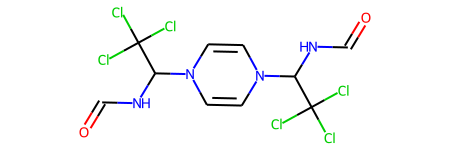

In [171]:
Chem.MolFromSmiles(molecule)

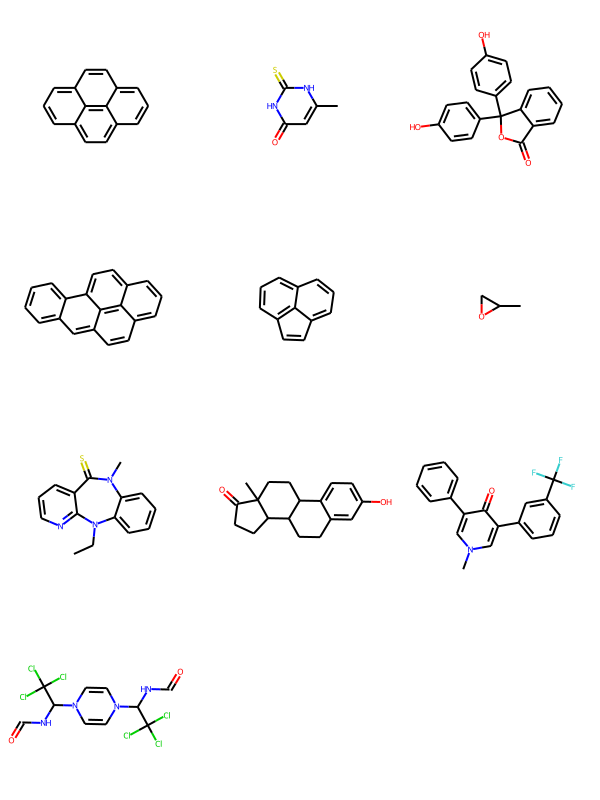

In [172]:


ms = [Chem.MolFromSmiles(x) for x in mol_list]
Draw.MolsToGridImage(ms)



## Graph convolution networks

In [173]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [174]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

In [175]:


model.fit(train_dataset, nb_epoch=100)



/home/ella/anaconda3/envs/ml_for_chemists/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.1087474536895752

In [176]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.9262812405775629}
Test set score: {'pearson_r2_score': 0.6816329411723037}


In [177]:
solubilities = model.predict_on_batch(test_dataset.X[:10])
mol_list=[]
for molecule, solubility in zip(test_dataset.ids, solubilities):
    print(solubility, molecule)
    mol_list.append(molecule)

[-1.9073966] c1cc2ccc3cccc4ccc(c1)c2c34
[0.4217861] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.8633107] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-2.0834172] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.3689758] C1=Cc2cccc3cccc1c23
[1.4357395] CC1CO1
[-0.7201981] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-1.0244131] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-1.3317294] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[-0.13841814] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 


In [178]:
tasks

['measured log solubility in mols per litre']

## Making your own models

In this section, we will write our own keras code to create different neural networks and see which is best for solving the delaney dataset

### Regression

In [179]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

In [180]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L1Loss())



In [181]:

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'pearson_r2_score': 0.8694946328487405}
test set score: {'pearson_r2_score': 0.634376666378724}


##### Things to add:

*layers*
1. tf.keras.layers.Dense(1000, activation='relu')
2. tf.keras.layers.Dropout(rate=0.5)
3. tf.keras.layers.BatchNormalization(),

You can change the number of neurons: 
`tf.keras.layers.Dense(*1000*, activation='relu')` --> `tf.keras.layers.Dense(*200*, activation='relu')`

You can change the activation function:
`tf.keras.layers.Dense(1000, activation=*'relu'*)` --> `tf.keras.layers.Dense(1000, activation=*'sigmoid'*)`

You can add in normalisation or [[]] layers:
`tf.keras.layers.Dropout(rate=0.5) (and you can change the rate)`
`tf.keras.layers.BatchNormalization()`

These are applied to `Dense` layers so need to come after them, e.g.: 

`keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])`

You can change the loss function:
dc.models.losses.L1Loss()
dc.models.losses.L2Loss()
dc.models.losses.L1Loss()
dc.models.losses.SigmoidCrossEntropy()
dc.models.losses.BinaryCrossEntropy()

In [182]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L1Loss())

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'pearson_r2_score': 0.8775775501057775}
test set score: {'pearson_r2_score': 0.6360057260554358}


In [183]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(200, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss())

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))



training set score: {'pearson_r2_score': 0.9775063817761833}
test set score: {'pearson_r2_score': 0.7173285889782063}


In [185]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss())

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

0.73-0.74

training set score: {'pearson_r2_score': 0.9696253604768071}
test set score: {'pearson_r2_score': 0.7318305561657411}


### Classificiation

A different network 

In [186]:
tasks, datasets, transformers = dc.molnet.load_bace_classification(feturizer='ECFP', splitter='scaffold')
train_dataset, valid_dataset, test_dataset = datasets

In [145]:
tasks, datasets, transformers = dc.molnet.load_bace_classification(feturizer='ECFP', splitter='scaffold')
train_dataset, valid_dataset, test_dataset = datasets

In [187]:
classification_model = tf.keras.Sequential([
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
])
model = dc.models.KerasModel(classification_model, dc.models.losses.SigmoidCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'roc_auc_score': 0.9436893203883495}
test set score: {'roc_auc_score': 0.7010869565217391}


#### Task: Make a better classification neural network

Try modifying the NN below to see if you can improve the ROC score on the test set. 

the best I've managed is 0.85

In [188]:
classification_model = tf.keras.Sequential([
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
])
model = dc.models.KerasModel(classification_model, dc.models.losses.SigmoidCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'roc_auc_score': 0.9588642872110078}
test set score: {'roc_auc_score': 0.7554347826086956}


In [189]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dense(1,activation='softmax'),
])
model = dc.models.KerasModel(classification_model, dc.models.losses.BinaryCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'roc_auc_score': 0.9996060627226375}
test set score: {'roc_auc_score': 0.7904438405797102}


In [192]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dense(1,activation='softmax'),
])
model = dc.models.KerasModel(classification_model, dc.models.losses.BinaryCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'roc_auc_score': 0.9996367954180345}
test set score: {'roc_auc_score': 0.8480072463768116}


In [193]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dense(1,activation='softmax'),
])
model = dc.models.KerasModel(classification_model, dc.models.losses.BinaryCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'roc_auc_score': 0.9996340015366347}
test set score: {'roc_auc_score': 0.8242753623188406}


## Splitting datasets to ensure a fair test

splitters = ['random', 'scaffold', 'butina']

In [194]:
split_method = 'butina'
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', splitter=split_method)
train_dataset, valid_dataset, test_dataset = datasets
model = dc.models.MultitaskClassifier(n_tasks=len(tasks), n_features=1024, layer_sizes=[1000])
model.fit(train_dataset, nb_epoch=10)
print('splitter:', splitter)
print('training set score:', model.evaluate(train_dataset, [metric], transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))
print()

splitter: butina
training set score: {'roc_auc_score': 0.9585322646171365}
test set score: {'roc_auc_score': 0.6020360440656412}



#### Task: try out the other options for splitting the dataset, which splitting method do you think is the best and why?

You may want to run this a few times and think about what the splits mean, do you trust all of the answers?

In [195]:
splitters = ['random', 'scaffold', 'butina']
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for splitter in splitters:
    tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', splitter=splitter)
    train_dataset, valid_dataset, test_dataset = datasets
    model = dc.models.MultitaskClassifier(n_tasks=len(tasks), n_features=1024, layer_sizes=[1000])
    model.fit(train_dataset, nb_epoch=10)
    print('splitter:', splitter)
    print('training set score:', model.evaluate(train_dataset, [metric], transformers))
    print('test set score:', model.evaluate(test_dataset, [metric], transformers))
    print()

splitter: random
training set score: {'roc_auc_score': 0.9545602678068751}
test set score: {'roc_auc_score': 0.7862011607303782}

splitter: scaffold
training set score: {'roc_auc_score': 0.95877916613216}
test set score: {'roc_auc_score': 0.6783032933872232}

splitter: butina
training set score: {'roc_auc_score': 0.9569020639243111}
test set score: {'roc_auc_score': 0.6064522492487645}



*Answer*: The scaffold split seems to give the best solution. The random split results must be rejected because a random split can make the problem too easy if the dataset is not balanced (which this isn't) and the fact that it gives vastly better results than the other two methods suggests that the random split results overestimate the goodness of the model.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets
n_tasks = len(tasks)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [ ]:
model = dc.models.GraphConvModel(n_tasks, mode='classification')

In [ ]:
model.tensorboard

#### Useful information: 

##### To see which datasets are available, run the code below.

See also: https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html 
which helpfully tells you the option you can use and the best splitter for that dataset

In [40]:
[method for method in dir(dc.molnet) if "load_" in method ]

['load_bace_classification',
 'load_bace_regression',
 'load_bandgap',
 'load_bbbc001',
 'load_bbbc002',
 'load_bbbp',
 'load_cell_counting',
 'load_chembl',
 'load_chembl25',
 'load_clearance',
 'load_clintox',
 'load_delaney',
 'load_factors',
 'load_function',
 'load_hiv',
 'load_hopv',
 'load_hppb',
 'load_kaggle',
 'load_kinase',
 'load_lipo',
 'load_mp_formation_energy',
 'load_mp_metallicity',
 'load_muv',
 'load_nci',
 'load_pcba',
 'load_pdbbind',
 'load_perovskite',
 'load_ppb',
 'load_qm7',
 'load_qm8',
 'load_qm9',
 'load_sampl',
 'load_sider',
 'load_sweet',
 'load_thermosol',
 'load_tox21',
 'load_toxcast',
 'load_uspto',
 'load_uv',
 'load_zinc15']